<a href="https://colab.research.google.com/github/Tyrannozavr/machine_learning/blob/master/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -o logo.png https://colab.research.google.com/img/colab_favicon_256px.png
!git clone https://github.com/CipiOrhei/TMBuD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4534  100  4534    0     0   138k      0 --:--:-- --:--:-- --:--:--  138k
Cloning into 'TMBuD'...
remote: Enumerating objects: 2504, done.
remote: Counting objects: 100% (798/798), done.
remote: Compressing objects: 100% (752/752), done.
remote: Total 2504 (delta 53), reused 789 (delta 46), pack-reused 1706
Receiving objects: 100% (2504/2504), 1.86 GiB | 32.83 MiB/s, done.
Resolving deltas: 100% (393/393), done.
Updating files: 100% (1585/1585), done.


In [2]:
%pip install poutyne
%pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 25.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 882.0 kB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=6438e7b4fa8ffbb84e4c9242203d922de02f63c603898c7770f40b850dd7f1d3
  Stored in directory: /root/.cache/pip/wheels/29/16/24/7

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
import pandas
import os
import torch
import cv2
from skimage.transform import resize
from google.colab.patches import cv2_imshow
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import albumentations as albu
from IPython.display import clear_output
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models

In [5]:
root = 'TMBuD/'
images_dir = root + 'images/'
lesions_dir = root + 'gt_label/'
dataset_csv = root + 'DATASET SPLIT.csv'

Ну я сразу скажу, что здесь вроде как предусмотрен какой то файл для более простой загрузки датасета, наверное, я сильно не разбирался, установил зависимости, он выдал мне какую то непонятную ошибку и я решил, что мне проще просто использовать эти картинки и не мучить голову свою

In [6]:
table = pandas.read_csv(dataset_csv)

In [7]:
table.head()

,Picture Name,Building Name,Coordinates Landmark,Coordinates image,GT salient edges,GT labels,Condition,Quality,Dataset STANDARD,Dataset 3_2,Dataset 3_5_NIGHT,Dataset 3_N,SEMSEG_EVAL_FULL,END
0,1,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75174775294593; 21.22478407583839,Done,Done,NIGHT,GOOD,TRAIN,None,TEST,TEST,TRAIN,'
1,2,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751577081296176; 21.22472497882864,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TRAIN,'
2,3,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,TRAIN,TRAIN,TRAIN,TRAIN,TEST,'
3,4,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.75127239101317; 21.22480049167443,Done,Done,DAY,GOOD,VAL,TEST,TEST,TEST,TRAIN,'
4,5,Orthodox Metropolitan Cathedral,45.750740690710934; 21.224235591324216,45.751259791003264; 21.224710204576198,Done,Done,DAY,GOOD,TEST,None,None,None,TRAIN,'


Так, ну для начала я понял, что смысла в этой таблице для меня особо нет т.к. здесь куча данных, но то, что мне нужно (например количество окон) отсутствует, как и адрес изображения, не знаю какой смысл мне в этой цифре, мол, вот 1 изображение. Была бы польза от полного имени

In [8]:
def get_name(numb):
    if len(str(numb)) == 1:
        return f'0000{numb}.png'
    if len(str(numb)) == 2:
        return f'000{numb}.png'
    if len(str(numb)) == 3:
        return f'00{numb}.png'
    if len(str(numb)) == 4:
        return f'0{numb}.png'
    if len(str(numb)) == 5:
        return f'{numb}.png'

In [42]:
images = []
lesions = []
size = (256, 256)

for i in range(1, 11000):
  img_or = cv2.imread(images_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  img_les = cv2.imread(lesions_dir+get_name(i), cv2.IMREAD_UNCHANGED)
  if img_or is not None and img_les is not None:
    images.append(img_or)
    lesions.append(img_les)

Дело в том, что для решения задачи сегментации мне понадобится метка здания, а для решения задачи регрессии, я думаю, мне понадобятся отмеченные окна, вот их метки я и буду подавать на регрессионную модель, возможно лучше даже обучить 2 разные модели, пока думаю над этим

Нужно оптимизировать этот алгоритм, бо это ужас, к сожалению не удалось сделать красиво одним срезом, похоже так только каждый элемент можно перебрать, ну или я не полностью знаю возможности numpy

Я все таки решил, что надеждней обучить 2 модели, одна будет рисовать фасад здания, другая делать сегментацию окон, дальше эти окна (ну, маску) либо на регрессию, либо даже что то попроще, просто сосчитат пространства зарисованные

Сейчас я попробую при помощи этой функции создать датасет для сегментации окон

In [10]:
%pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
from tqdm import tqdm

Следующий цикл проходит по сегментированным изображениям и всего лишь удаляет все, кроме окон, ну и я решил раз уж классов всего 2 (окна и не окна), из 3 слоев сделать один

In [44]:
len(df_windows)

298

100%|██████████| 298/298 [17:17<00:00,  3.48s/it]


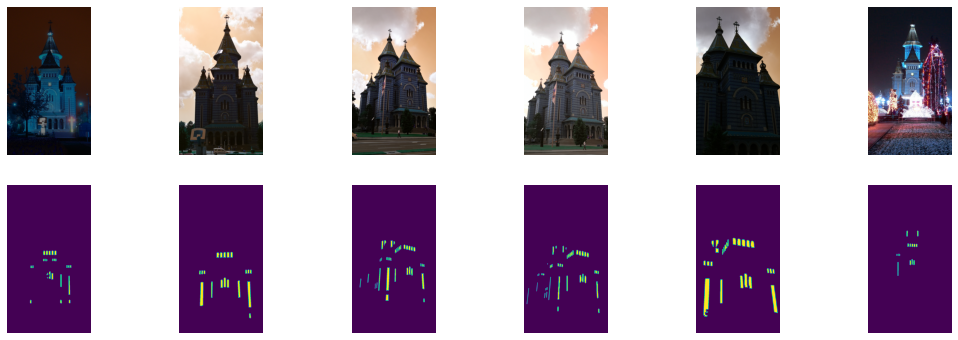

In [12]:
df_windows = []
for image in tqdm(lesions):
  les = np.zeros(image.shape[:2])
  for idx_row, row in enumerate(image):
    for idx_col, cell in enumerate(row):
      if any(cell != [0, 255, 255]):
        les[idx_row, idx_col] = 0
      else:
        les[idx_row, idx_col] = 1
  df_windows.append(les)

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(images[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(df_windows[i])
plt.show();

In [13]:
def showing_result(image, result):
  plt.figure(figsize=(18, 6))
  for i in range(6):
      plt.subplot(2, 6, i+1)
      plt.axis("off")
      plt.imshow(image[i].numpy().transpose(1, 2, 0))

      plt.subplot(2, 6, i+7)
      plt.axis("off")
      plt.imshow(result[i].squeeze())
  plt.show();

In [61]:
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) for y in df_windows]

In [46]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [200, 275])

In [69]:
X, Y = np.array(X, dtype=np.float32), np.array(Y, np.float32)

In [63]:
# tr.dtype

In [70]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [71]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


Начнем собирать и тренировать модель

Здесь просто происходит обработка данных в соответствии с обучаемой моделью

In [20]:
# ENCODER_WEIGHTS = 'imagenet'
# ACTIVATION = 'sigmoid' 

# seg_model = smp.Unet(
#     encoder_name=BACKBONE,
#     encoder_weights=ENCODER_WEIGHTS, 
#     classes=1, 
#     activation=ACTIVATION,
# )

In [21]:
test_x, test_y= next(iter(data_tr))

In [22]:
# test_x = test_x.float()
seg_model = smp.Unet(
    encoder_name='resnet34', 
    encoder_weights='imagenet', 
    classes=1, 
    activation='sigmoid',
)
imgs = seg_model(test_x)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [23]:
imgs = imgs.detach().numpy()

In [24]:
test_x.shape

torch.Size([25, 3, 256, 256])

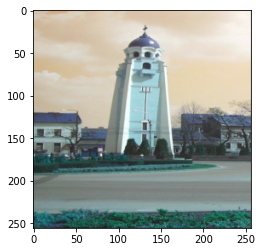

In [25]:
# plt.imshow(resize(test_x[0], (256, 256, 3)))
plt.imshow(test_x[0].numpy().transpose(1, 2, 0))

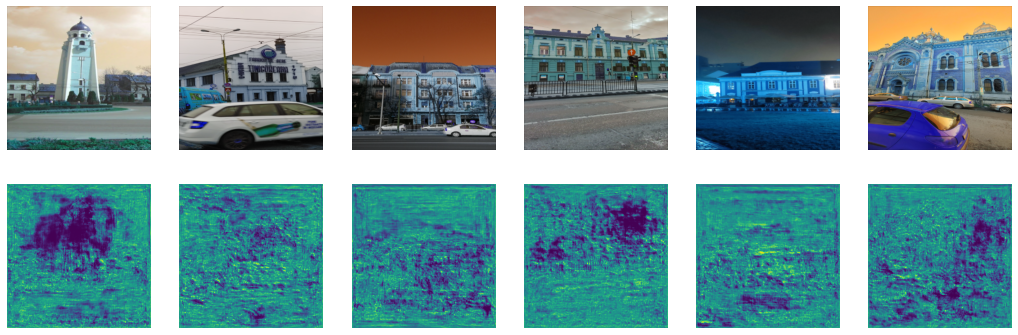

In [26]:
showing_result(test_x, imgs)

Обучение модели

In [ ]:
%pip install pytorch-lightning==1.5.4

In [28]:
X.shape, Y.shape

((298, 256, 256, 3), (298, 256, 256))

In [29]:
# Here we simply pass the input images through the model like we are making a prediction.
images, masks = next(iter(data_tr))
seg_preds = seg_model(images)

# loss
# seg_criterion = smp.utils.losses.DiceLoss()
# seg_loss = seg_criterion(seg_preds, masks).item()


print(seg_preds.shape)
# print(seg_loss)

torch.Size([25, 1, 256, 256])


In [30]:
def bce_loss(y_real, y_pred):
  y_pred = torch.sigmoid(y_pred)
  res = y_real * torch.log(y_pred) + (1 - y_real)*torch.log(1 - y_pred)
  return -res.mean()

In [31]:
from time import time

In [72]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device, dtype=torch.float)
            Y_batch = Y_batch.to(device, dtype=torch.float)
            # print('batch')
            opt.zero_grad()
            # data to device

            # set parameter gradients to zero

            # forward
            Y_pred = model.forward(X_batch)
            loss =  loss_fn(Y_pred, Y_batch)# forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model.forward(X_val.to(device)).detach().cpu()# detach and put into cpu

        plt.figure(figsize=(18, 6))
        clear_output(wait=True)
        for i in range(6):
            plt.subplot(2, 6, i+1)
            plt.axis("off")
            plt.imshow(X_val[i].numpy().transpose(1, 2, 0))

            plt.subplot(2, 6, i+7)
            plt.axis("off")
            plt.imshow(Y_hat[i].squeeze())
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show();

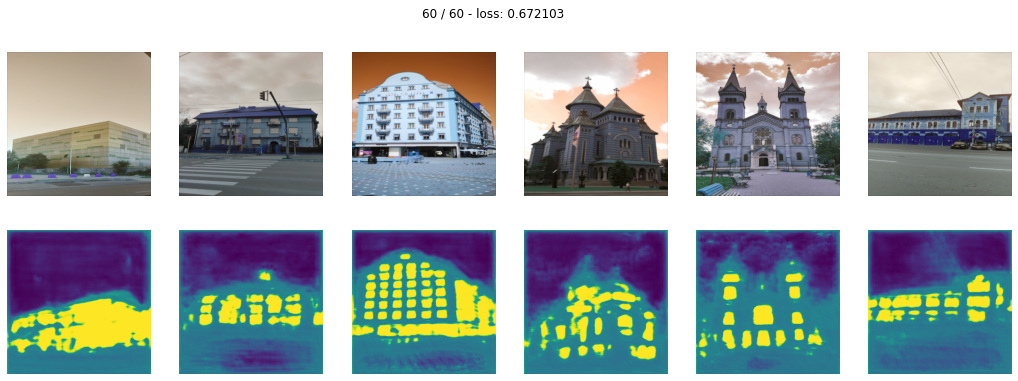

In [78]:
max_epochs = 60
optim = torch.optim.Adam(seg_model.parameters(), lr=0.0001)
seg_model.to(device)
train(seg_model, optim, bce_loss, max_epochs, data_tr, data_val)

In [110]:
torch.save(seg_model.state_dict(), 'seg_model.pt')
files.download('seg_model.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
from google.colab import files


In [104]:
with torch.no_grad():
  x = next(iter(data_ts))[0]
  x = x.to(device)
  res = seg_model(x)
  res[res<0.7] = 0
  res = res.cpu().detach().numpy()
  x = x.cpu()
showing_result(x, res)

In [99]:
# files.download('seg_model.pt')

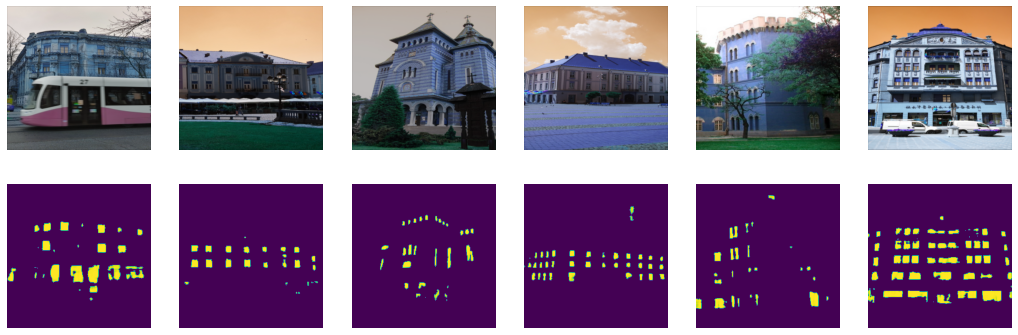

In [108]:
with torch.no_grad():
  x = next(iter(data_ts))[0]
  x = x.to(device)
  res = seg_model(x)
  res[res<0.7] = 0
  res = res.cpu().detach().numpy()
  x = x.cpu()
showing_result(x, res)

In [106]:
def dice_loss(y_real, y_pred):
    y_real, y_pred = y_real.view(-1), y_pred.view(-1)
    num = torch.sum(2*y_real*y_pred)
    den = y_real.sum() + y_pred.sum()
    res = 1 - (num + 1*10**-8) / (den + 1*10**-8)
    return res

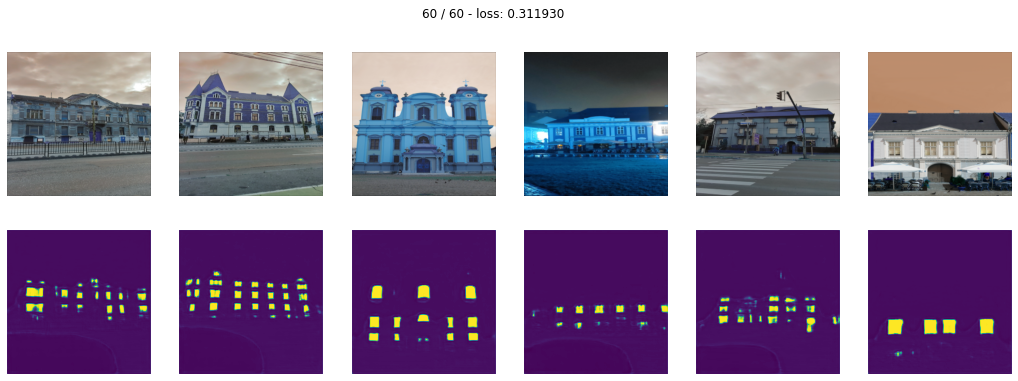

In [107]:
max_epochs = 60
optim = torch.optim.Adam(seg_model.parameters(), lr=0.0001)
seg_model.to(device)
train(seg_model, optim, dice_loss, max_epochs, data_tr, data_val)

Честно говоря, я не ожидал, что изменение функции потерь так сильно улучшит результат, я доволен, мне жаль, что я не написал метрики, но кажется уже не успеваю, на решение это не повлияет, но еще пару дней и оформил бы красиво, а так еще слишком много нужно сделать(

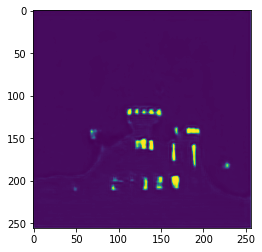

In [237]:
def show_mask(image):
  '''image view (256, 256)'''
  plt.imshow(image.squeeze())
show_mask(result)

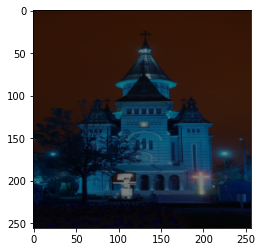

In [244]:
def segm_windows(x):
  '''
  x must be a numpy array view [256, 256, 3]
  '''
  x = x[np.newaxis]
  x = np.rollaxis(x, 3, 1)
  x = torch.tensor(x)
  x = x.to(device)
  result = seg_model(x)
  result = result.cpu().detach().numpy()
  return result[0][0]
photo = X[0]
result = segm_windows(photo)
plt.imshow(photo)

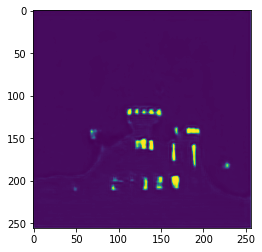

In [245]:
show_mask(result)

теперь надо циклом вот так вот обработать все изображения и вручную разметить количество окон((